Investigate the effect of school status on smartwatch wear rate

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


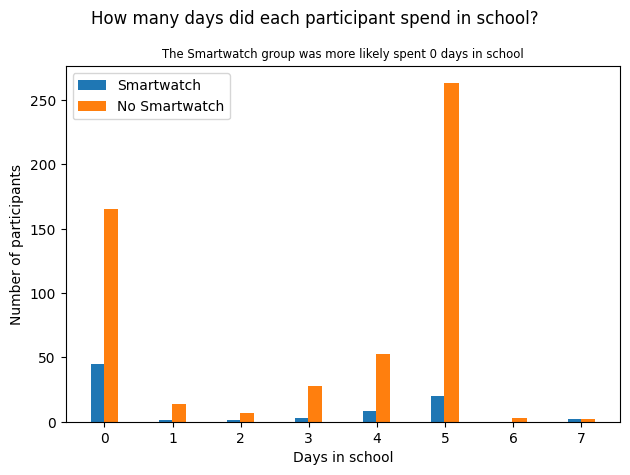

In [41]:
"""
Make a histogram of how many days each participant spent in school

"""
import numpy as np
import matplotlib.pyplot as plt

from ema import read

schooldays_with_watch = read.n_days_in_school(subset="smartwatch")
schooldays_no_watch = read.n_days_in_school(subset="not smartwatch")

fig, axis = plt.subplots()
bins1 = np.sort(np.concatenate([np.arange(8) - 0.2, np.arange(8) + 0.01]))
bins2 = np.sort(np.concatenate([np.arange(8) - 0.01, np.arange(8) + 0.2]))
density = False
axis.hist(
    schooldays_with_watch.values(), bins=bins1, label="Smartwatch", density=density
)
axis.hist(
    schooldays_no_watch.values(), bins=bins2, label="No Smartwatch", density=density
)

fig.suptitle("How many days did each participant spend in school?")
axis.set_title(
    "The Smartwatch group was more likely spent 0 days in school", fontsize="small"
)
axis.set_ylabel(f"{'Fraction' if density else 'Number'} of participants")
axis.set_xlabel("Days in school")
axis.legend()

fig.tight_layout()

fig.savefig(f"img/schooldays{'_scaled' if density else ''}.png")

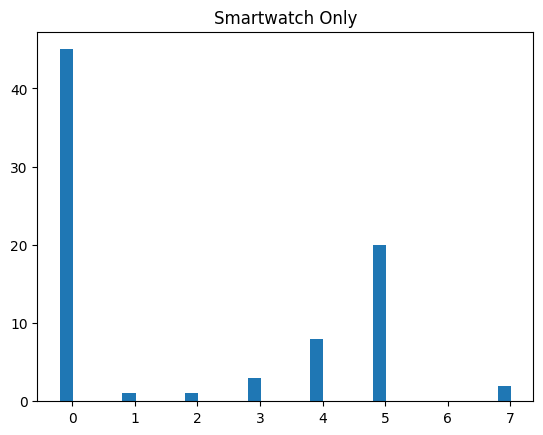

In [18]:
plt.hist(schooldays_with_watch.values(), bins=bins1)
plt.title("Smartwatch Only")

plt.savefig("img/schooldays_watch_only.png")

In [19]:
x = np.array(list(schooldays_with_watch.values()))
x = x[~(np.isnan(x) | (x == -99))]

np.unique(x, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 7.]), array([45,  1,  1,  3,  8, 20,  2]))

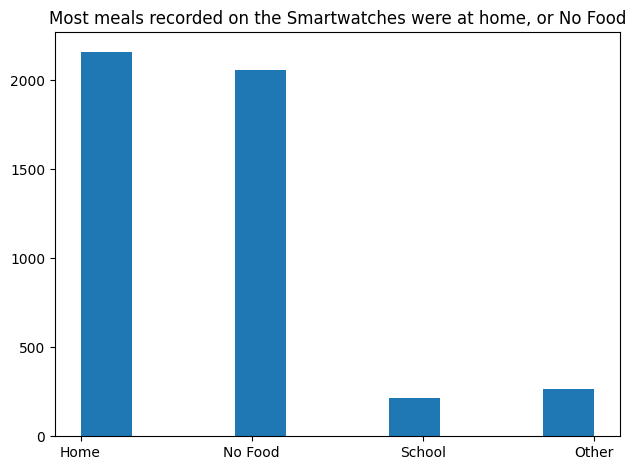

In [20]:
"""
Find what proportion of entries were at home/school/other, overall and as a function of how many days spent in school

"""
from ema import clean

meal_types = {"Meal", "Drink", "Snack", "No food/drink"}
meal_info = clean.cleaned_smartwatch(keep_catchups=False)

plt.hist(meal_info[meal_info["meal_type"].isin(meal_types)]["location"])

plt.xticks(plt.gca().get_xticks(), ["Home", "No Food", "School", "Other"])

plt.title("Most meals recorded on the Smartwatches were at home, or No Food")

plt.tight_layout()

plt.savefig("img/meal_locations.png")

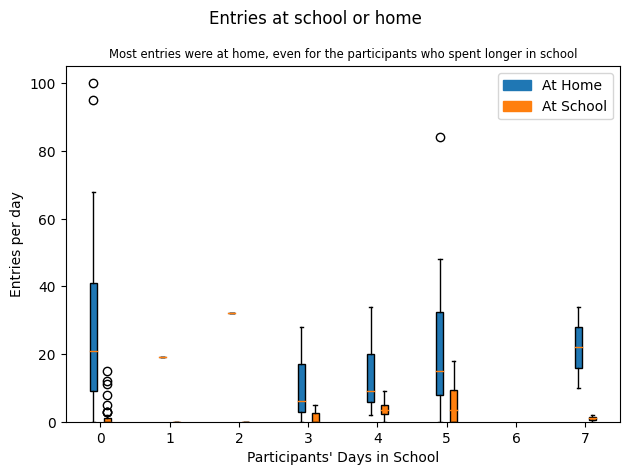

In [21]:
"""
Find the fraction of entries that were at school or at home for each participant and plot it against how many days they spent in school

"""
from matplotlib.patches import Patch

fig, axis = plt.subplots()

days_in_school = np.array(list(schooldays_with_watch.values()))
entries_in_school = np.zeros_like(days_in_school)
entries_at_home = np.zeros_like(days_in_school)

for i, participant in enumerate(schooldays_with_watch):
    df_slice = meal_info.query("p_id == @participant")

    # Find how many entries were at school
    n_in_school = (df_slice["location"] == "School").sum()

    # Find how many entries were at home
    n_at_home = (df_slice["location"] == "Home").sum()

    entries_in_school[i] = n_in_school
    entries_at_home[i] = n_at_home


# Split the data by how many days spent in school
inschool_by_day = [[] for _ in range(8)]
for days, entries in zip(days_in_school, entries_in_school):
    if np.isnan(days) or days == -99:
        continue
    inschool_by_day[int(days)].append(entries)

athome_by_day = [[] for _ in range(8)]
for days, entries in zip(days_in_school, entries_at_home):
    if np.isnan(days) or days == -99:
        continue
    athome_by_day[int(days)].append(entries)


# Filter out empty days
days = []
inschool_by_day_filtered = []
athome_by_day_filtered = []
for i in range(8):
    if len(inschool_by_day[i]) > 0 and len(athome_by_day[i]) > 0:
        days.append(i)
        inschool_by_day_filtered.append(inschool_by_day[i])
        athome_by_day_filtered.append(athome_by_day[i])

days = np.array(days)

home_box = axis.boxplot(
    athome_by_day_filtered, positions=days - 0.1, widths=0.1, patch_artist=True
)
school_box = axis.boxplot(
    inschool_by_day_filtered, positions=days + 0.1, widths=0.1, patch_artist=True
)


for box in home_box["boxes"]:
    box.set_facecolor("C0")
    box.set_edgecolor("k")

for box in school_box["boxes"]:
    box.set_facecolor("C1")
    box.set_edgecolor("k")

axis.legend(
    [
        Patch(color=home_box["boxes"][0].get_facecolor()),
        Patch(color=school_box["boxes"][0].get_facecolor()),
    ],
    ["At Home", "At School"],
)

fig.suptitle("Entries at school or home")
axis.set_title(
    "Most entries were at home, even for the participants who spent longer in school",
    fontsize="small",
)

axis.set_xlim(-0.5, 7.5)
axis.set_ylim(0.0, axis.get_ylim()[1])
axis.set_xlabel("Participants' Days in School")
axis.set_ylabel("Entries per day")
axis.set_xticks(range(8), range(8))

fig.tight_layout()
fig.savefig("img/entries_at_school_or_home.png")

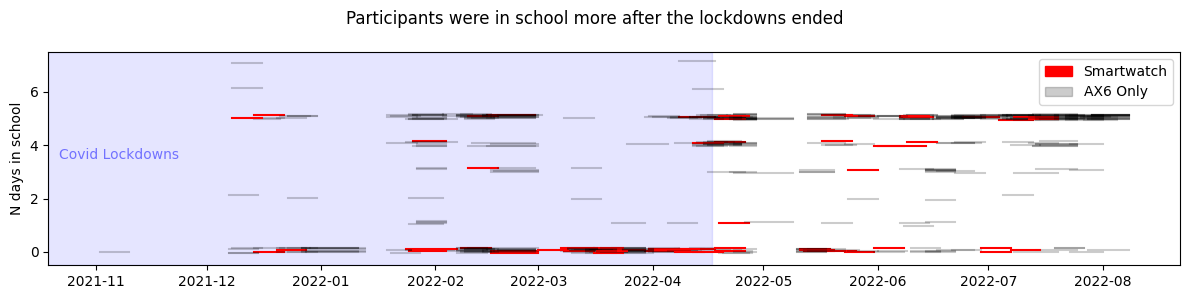

In [22]:
"""
Show the dates where the smartwatch and non-smartwatch entries were recorded

"""
import pandas as pd
from matplotlib.patches import Patch

from ema import util

gen = np.random.default_rng(seed=0)


# Flag for random or meaningful y axis
randomy = False

ymax = 1.0 if randomy else 7.5
ymin = 0.0 if randomy else -0.5

fig, axis = plt.subplots(figsize=(12, 3))
feasibility_df = read.smartwatch_feasibility()[
    [
        "smartwatchwilling",
        "actualdateofdistribution1st",
        "collectiondate_actual",
        "residents_id",
    ]
]
plot_kw = {2.0: {"color": "k", "alpha": 0.2}, 1.0: {"color": "r"}}
for _, row in feasibility_df.iterrows():
    x = [row["actualdateofdistribution1st"], row["collectiondate_actual"]]
    diff = x[1] - x[0]
    if diff is pd.NaT or diff < pd.Timedelta(days=0):
        continue

    if randomy:
        y = [0.025 + 0.95 * gen.random()] * 2
    else:
        try:
            y = schooldays_no_watch[row["residents_id"]]
        except KeyError:
            y = schooldays_with_watch[row["residents_id"]]
        y += 0.2 * (gen.random() - 0.2)
        y = [y] * 2

    axis.plot(x, y, **plot_kw[row["smartwatchwilling"]])


# Indicate lockdown dates
xlim = axis.get_xlim()
axis.fill_betweenx(
    [ymin, ymax],
    xlim[0],
    util.lockdown_end(),
    color="b",
    alpha=0.1,
)
axis.set_xlim(xlim)
axis.set_ylim(ymin, ymax)

if randomy:
    axis.get_yaxis().set_visible(False)
else:
    axis.set_ylabel("N days in school")

axis.legend(
    handles=[Patch(**plot_kw[1.0]), Patch(**plot_kw[2.0])],
    labels=["Smartwatch", "AX6 Only", "Covid Lockdowns"],
    loc="upper right",
)
axis.text(0.01, 0.5, "Covid Lockdowns", color="b", transform=axis.transAxes, alpha=0.5)

title = (
    "Participant Start and End Dates"
    if randomy
    else "Participants were in school more after the lockdowns ended"
)
fig.suptitle(title)
fig.tight_layout()
fig.savefig("img/start_and_ends.png")

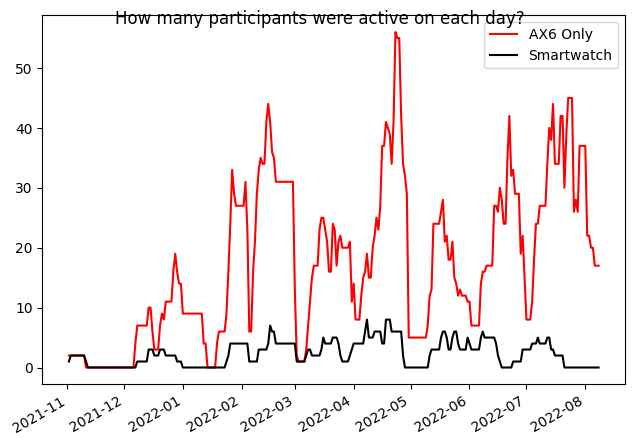

In [23]:
"""
Show how many participants of each type took part by date

"""
# Read in feasibility info
feasibility_df = read.smartwatch_feasibility()
feasibility_df = feasibility_df.loc[
    :,
    [
        "smartwatchwilling",
        "actualdateofdistribution1st",
        "collectiondate_actual",
        "residents_id",
    ],
]
# Keep only valid entries (where the end was between 0 and 11 days after the start)
feasibility_df["length"] = (
    feasibility_df["collectiondate_actual"]
    - feasibility_df["actualdateofdistribution1st"]
)
feasibility_df = feasibility_df.loc[(feasibility_df["length"] > pd.Timedelta(days=0))]

# Find the start and end of the period as a date range
start = feasibility_df["actualdateofdistribution1st"].min()
end = feasibility_df["collectiondate_actual"].max()

days = pd.date_range(start, end, freq="1D")
n_no_watch = np.zeros(len(days), dtype=int)
n_with_watch = np.zeros(len(days), dtype=int)

# For each date, find whether it falls in each date range
for i, day in enumerate(days):
    # Find how many smartwatch and how many non-smartwatch participants were active on each date
    active_on_day = (feasibility_df["actualdateofdistribution1st"] <= day) & (
        feasibility_df["collectiondate_actual"] >= day
    )

    df_slice = feasibility_df.loc[active_on_day]

    n_no_watch[i] = (df_slice["smartwatchwilling"] == 2.0).sum()
    n_with_watch[i] = (df_slice["smartwatchwilling"] == 1.0).sum()

# Plot
fig, axis = plt.subplots()
axis.plot(days, n_no_watch, color="r", label="AX6 Only")
axis.plot(days, n_with_watch, color="k", label="Smartwatch")

xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
axis.fill_betweenx(
    [ylim[0], ylim[1]],
    xlim[0],
    util.lockdown_end(),
    color="b",
    alpha=0,
)
axis.set_ylim(ylim)
axis.set_xlim(xlim)

axis.legend()
fig.tight_layout()
fig.autofmt_xdate()

fig.suptitle("How many participants were active on each day?")
fig.savefig("img/n_per_day.png")

/tmp/ipykernel_6763/3051928830.py:36: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


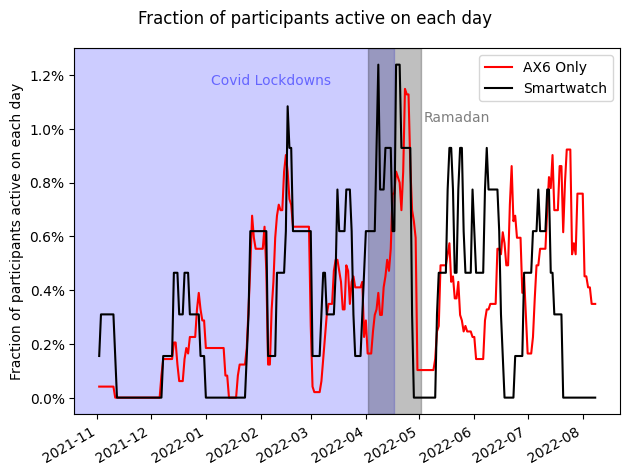

In [39]:
"""
Plot a scaled version

"""
from ema import plotting

fig, axis = plt.subplots()
axis.plot(days, n_no_watch / n_no_watch.sum(), color="r", label="AX6 Only")
axis.plot(days, n_with_watch / n_with_watch.sum(), color="k", label="Smartwatch")

xlim, ylim = axis.get_xlim(), axis.get_ylim()
axis.fill_betweenx(
    [ylim[0], ylim[1]],
    xlim[0],
    util.lockdown_end(),
    color="b",
    alpha=0.2,
)
axis.set_ylim(ylim)
axis.set_xlim(xlim)

axis.legend()
fig.tight_layout()
fig.autofmt_xdate()

axis.set_ylabel("Fraction of participants active on each day")
axis.set_yticks(
    axis.get_yticks()[1:-1], [f"{100 * y:.1f}%" for y in axis.get_yticks()[1:-1]]
)

plotting.shade_ramadan(axis)
axis.text(0.64, 0.8, "Ramadan", color="k", alpha=0.5, transform=axis.transAxes)
axis.text(0.25, 0.9, "Covid Lockdowns", transform=axis.transAxes, alpha=0.5, color="b")

fig.suptitle("Fraction of participants active on each day")
fig.tight_layout()

fig.savefig("img/n_per_day_scaled.png")

In [10]:
"""
Find the fraction of entries that were at home/school/other for each participant

"""
n_school = np.zeros(8)
n_home = np.zeros(8)
n_other = np.zeros(8)
n_no_response = np.zeros(8)
n_total = np.zeros(8)
for p_id in meal_info["p_id"].unique():
    # Find how many days the participant spent in school
    idx = schooldays_with_watch[p_id]

    if np.isnan(idx) or idx == -99:
        print(f"Skipping participant {p_id}")
        continue

    idx = int(idx)

    # Find the total for each participant
    df_slice = meal_info.query("p_id == @p_id")
    n_total[idx] += len(df_slice)

    # Find the total number of entries made in each location
    n_school[idx] += (df_slice["location"] == "School").sum()
    n_home[idx] += (df_slice["location"] == "Home").sum()
    n_other[idx] += (df_slice["location"] == "Elsewhere").sum()
    n_no_response[idx] += (df_slice["location"] == "No response").sum()


assert (
    n_total == n_school + n_home + n_other + n_no_response
).all(), f"{n_total}, {n_school}, {n_home}, {n_other}, {n_no_response}"

school_frac = n_school / n_total
home_frac = n_home / n_total
other_frac = n_other / n_total

Skipping participant 16231
Skipping participant 23158
Skipping participant 15439
Skipping participant 18604
Skipping participant 9891


/tmp/ipykernel_6763/214533521.py:35: RuntimeWarning: invalid value encountered in divide
  school_frac = n_school / n_total
/tmp/ipykernel_6763/214533521.py:36: RuntimeWarning: invalid value encountered in divide
  home_frac = n_home / n_total
/tmp/ipykernel_6763/214533521.py:37: RuntimeWarning: invalid value encountered in divide
  other_frac = n_other / n_total


Text(0, 0.5, 'Fraction of entries')

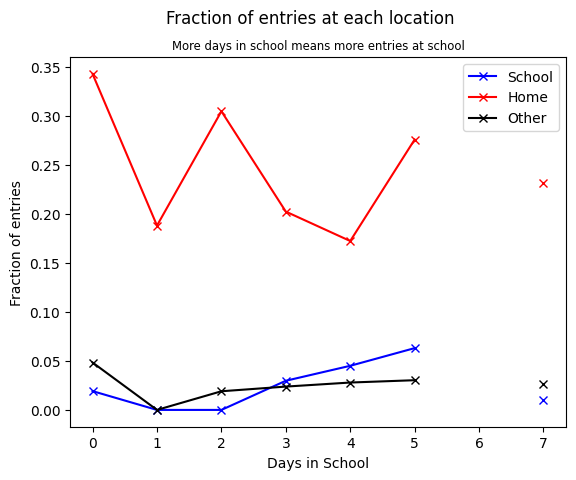

In [11]:
"""
Plot the fraction of entries that were at home/school/other for each participant

"""
days_in_school = np.arange(8)

fig, axis = plt.subplots()

axis.plot(days_in_school, school_frac, "bx-", label="School")
axis.plot(days_in_school, home_frac, "rx-", label="Home")
axis.plot(days_in_school, other_frac, "kx-", label="Other")

axis.legend()
fig.suptitle("Fraction of entries at each location")
axis.set_title("More days in school means more entries at school", fontsize="small")

axis.set_xlabel("Days in School")
axis.set_ylabel("Fraction of entries")

In [12]:
"""
Multi level model - we want to check if number of days in school affects the rate at which participants respond

"""
import pymc as pm
import pandas as pd

# Create a dataframe with the data we need
model_df = pd.DataFrame()
model_df["p_id"] = meal_info["p_id"]
model_df["days_in_school"] = meal_info["p_id"].map(schooldays_with_watch)


# Whether each entry was a response or not
model_df["entry"] = (
    meal_info["meal_type"].isin({"Meal", "Drink", "Snack", "No food/drink"}).astype(int)
)

# Keep only valid values
keep = ~(model_df["days_in_school"].isna() | (model_df["days_in_school"] == -99))
model_df = model_df[keep]

print(model_df)


def linear_model(model_df: pd.DataFrame):
    # Define the model
    with pm.Model() as model:
        # Priors
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        schooldays_coef = pm.Normal("days_in_school", mu=0, sigma=10)
        p_id_sd = pm.HalfNormal("p_id_sd", sigma=10)
        p_id = pm.Normal("p_id", mu=0, sigma=p_id_sd, shape=model_df["p_id"].nunique())

        model_df["p_id"] = model_df["p_id"].astype("category").cat.codes

        # Expected value of outcome (using the logit link function)
        logit_p = intercept + schooldays_coef * model_df["days_in_school"] + p_id[model_df["p_id"]]

        # Likelihood
        entry = pm.Binomial(
            "entry", n=1, p=pm.math.invlogit(logit_p), observed=model_df["entry"]
        )

        # Fit the model
        trace = pm.sample(draws=2000, tune=1000, target_accept=0.95)

    return model, trace


# Print the summary
model, trace = linear_model(model_df)
pm.summary(trace)

                      p_id  days_in_school  entry
Datetime                                         
2021-11-30 08:02:05  20029             5.0      0
2021-11-30 08:02:19  16401             0.0      0
2021-11-30 09:04:05  20029             5.0      0
2021-11-30 09:04:19  16401             0.0      0
2021-11-30 10:05:06  20029             5.0      1
...                    ...             ...    ...
2022-07-26 16:12:14  39055             5.0      1
2022-07-26 17:12:20  39055             5.0      1
2022-07-26 18:14:20  39055             5.0      0
2022-07-26 19:14:24  39055             5.0      1
2022-07-26 20:14:34  39055             5.0      1

[6558 rows x 3 columns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, days_in_school, p_id_sd, p_id]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.783,0.145,0.499,1.053,0.005,0.003,963.0,1824.0,1.01
days_in_school,-0.050,0.047,-0.136,0.039,0.001,0.001,1042.0,2134.0,1.00
p_id[0],-0.172,0.272,-0.693,0.329,0.006,0.004,2354.0,3980.0,1.00
p_id[1],-1.307,0.235,-1.761,-0.880,0.004,0.003,3506.0,4448.0,1.00
p_id[2],0.336,0.264,-0.176,0.821,0.005,0.003,3193.0,4293.0,1.00
...,...,...,...,...,...,...,...,...,...
p_id[74],0.137,0.289,-0.395,0.692,0.006,0.004,2526.0,3873.0,1.00
p_id[75],0.009,0.249,-0.477,0.460,0.005,0.003,2846.0,4486.0,1.00
p_id[76],-0.717,0.322,-1.348,-0.137,0.005,0.004,3475.0,5092.0,1.00
p_id[77],-0.109,0.250,-0.608,0.334,0.005,0.003,2786.0,4311.0,1.00


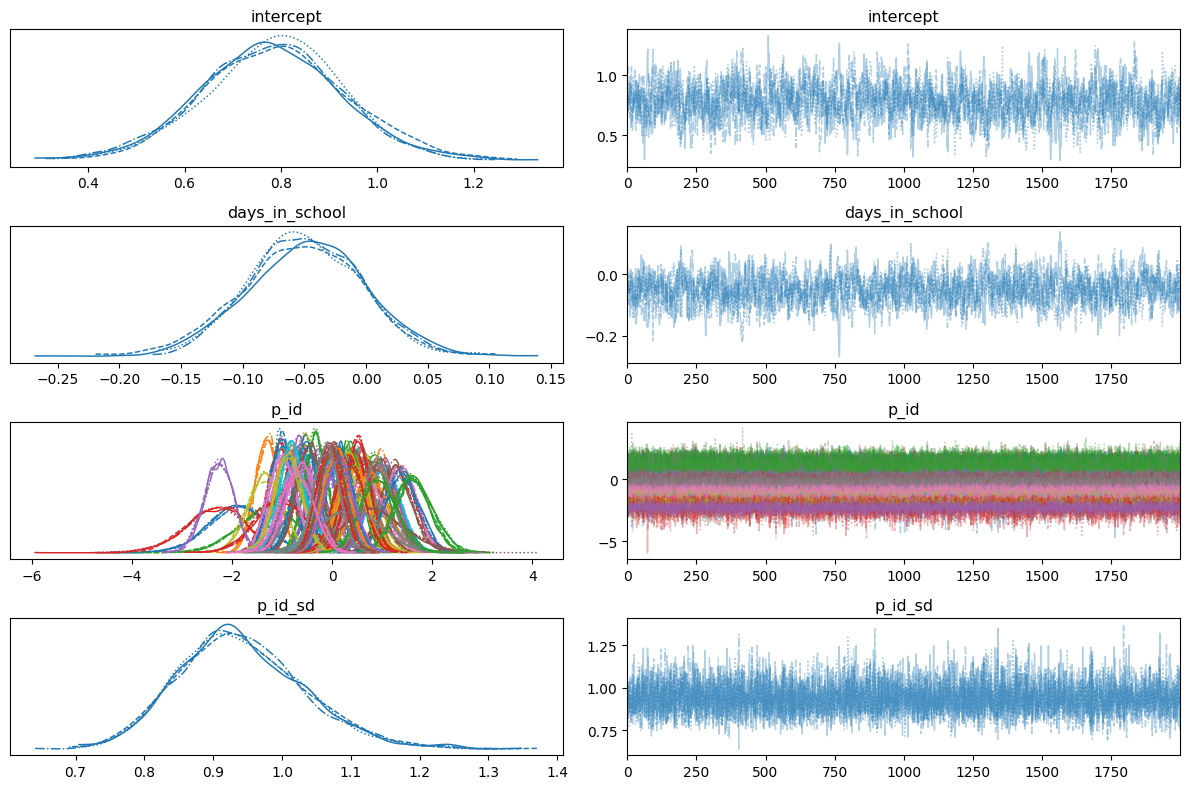

In [13]:
axes = pm.plot_trace(trace)
fig = axes.ravel()[0].get_figure()
fig.tight_layout()

mean           -0.050
sd              0.047
hdi_5%         -0.126
hdi_95%         0.028
mcse_mean       0.001
mcse_sd         0.001
ess_bulk     1042.000
ess_tail     2134.000
r_hat           1.000
Name: days_in_school, dtype: float64


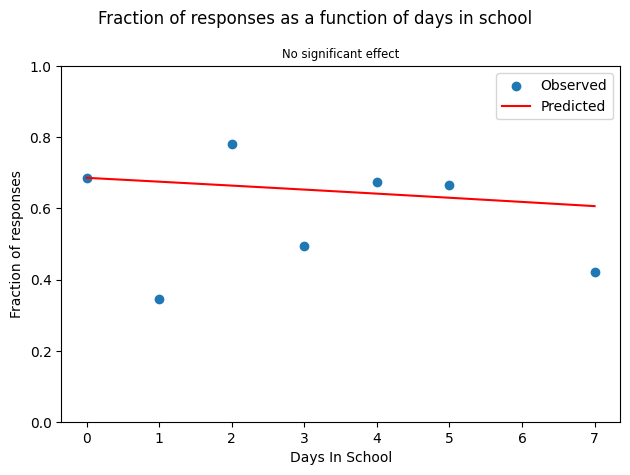

In [14]:
print(pm.summary(trace, hdi_prob=0.90).loc["days_in_school"])  # 95% HPD

fig, axis = plt.subplots()

# Group data by day and calculate mean of entry
grouped = model_df.groupby("days_in_school")["entry"].mean()

# Plot percentage of entries that equal 1
axis.scatter(grouped.index, grouped, label="Observed")

# Calculate predicted probabilities
days = np.arange(0, 8)
pred_probs = pm.invlogit(
    trace.posterior["intercept"].mean().item()
    + trace.posterior["days_in_school"].mean().item() * days
).eval()

# Plot predicted probabilities
axis.plot(days, pred_probs, color="red", label="Predicted")

axis.set_xlabel("Days In School")
axis.set_ylabel("Fraction of responses")

axis.set_ylim(0, 1)

axis.legend()

fig.suptitle("Fraction of responses as a function of days in school")
axis.set_title("No significant effect", fontsize="small")
fig.tight_layout()

fig.savefig("img/mlm_schooldays.png")